In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
# PATH = "/home/ubuntu/data/dogscats_sample/"
PATH = "/home/ubuntu/data/idilityhackatonseeds/"

sz = 350
arch = resnet34
bs = 64

In [3]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1), test_name='test')
load_learner = ConvLearner.pretrained(arch, data, precompute=False, opt_fn=optim.Adam, ps=0.5)

load_learner.load('350_all_resnet34')
m = load_learner.model

In [4]:
m

Sequential (
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, 

Removing the last layers and add a Convolution layer to synthesize the classiness of each sample. Do not know if it's a better way to do that, I am opened to suggestions

In [5]:
m = nn.Sequential(*children(m)[:-10], 
                  nn.Conv2d(512, 5, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
learn = ConvLearner.from_model_data(m, data)
learn.model

Sequential (
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, 

Freeze everything but the last 4 layers. Make the last and the fourth last layers trainable

In [7]:
learn.freeze_to(-4)
m[-1].trainable
m[-4].trainable

True

In [8]:
m[-4]

Conv2d(512, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [9]:
m[-1]

LogSoftmax ()

In [10]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.210508   0.0        1.0       



[1.0058284e-07, 1.0]

In [11]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.023708   0.0        1.0       



[0.0, 1.0]

In [12]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [13]:
dt = iter(data.test_dl)
X,y = next(dt)

In [14]:
x = X[None,17]
dx = data.test_ds.denorm(x)[0]

In [15]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 0.,  0.,  0.,  1.,  0.], dtype=float32)

In [16]:
feat = np.maximum(0, sf.features[0])
feat.shape

(5, 11, 11)

In [17]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
# f2;

The command plt.subplots_adjust can be used to adjust the spacing between these plots. 

In [18]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


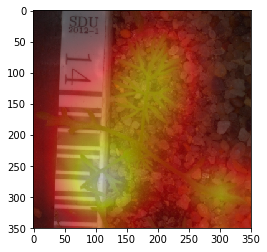

In [19]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

In [20]:
img_path = f'{PATH}/test/f76772c24.png';

In [21]:
# Some Helper functions
from PIL import Image
def image_loader(path, expand_dim=False):
    img = Image.open(path)
    img = img.resize((sz, sz))
    dx = np.array(img)
    img = np.array(img, dtype=np.float32)
    img = np.einsum('ijk->kij', img)
    if expand_dim:
        img = img[None]
#     # convert to torch 
    img = torch.from_numpy(img)
    return img, dx 

In [22]:
x, dx = image_loader(img_path, expand_dim=True)

In [23]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 0.     ,  0.     ,  1.     ,  0.00001,  0.     ], dtype=float32)

In [24]:
feat = np.maximum(0, sf.features[0])
feat.shape

(5, 11, 11)

In [25]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
# f2;

The command plt.subplots_adjust can be used to adjust the spacing between these plots. 

In [26]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


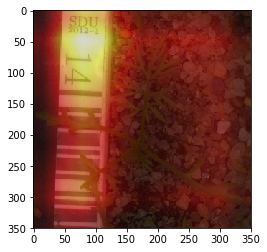

In [27]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');